# EMI AND LOAN CALCULATION

## Calculate emi taking average of all major banks across 20 years
### average rates :

     | Bank / Lender         | Typical Floating Rate (p.a.)|
     | --------------------- | ------------------ |
     | SBI                   | ~7.50% – 8.70%+ |
     | HDFC Bank             | ~7.90% – 13.20% |
     | ICICI Bank            | ~8.75% – 9.80% |
     | Kotak Mahindra        | ~7.99% – 13.3% |
     | Union Bank of India   | ~7.45% – 10% |
     | Canara Bank           | ~7.40% – 10.25% |
     | Central Bank of India | ~7.35% – 9.40% |
     | Bajaj Housing Finance | ~7.40% – 10.25% |
     | Indian Bank           | ~7.40% – 8.80% |

we take the average rate as : 
# assumed_home_loan_rate = 8.0


### For FY 2025-26 (assessment year 2026-27), the new tax regime (optional under section 115BAC) has lower and simplified tax rates:

     ₹0 – ₹4 L: Nil

     ₹4 L – ₹8 L: 5%

     ₹8 L – ₹12 L: 10%

     ₹12 L – ₹16 L: 15%

     ₹16 L – ₹20 L: 20%

     ₹20 L – ₹24 L: 25%

     Above ₹24 L: 30%

### Under the old tax regime (still allowed if you choose it when filing ITR):

     Section 24(b): Interest deduction

          Up to ₹2,00,000 per year for self-occupied property

          No limit for rented out properties

     Section 80(C): Principal repayment

          Deduction up to ₹1,50,000 per year


# we are gonna be using both the tax regimes and at last we choose the one which is beneficial (as it is still allowed if you choose it when filing ITR )


# what this code does right now:
     How much loan a buyer can realistically take
     Whether a property is affordable given income constraints
     The true EMI burden and its composition (interest vs principal)  
     The risk profile of the purchase before comparing it with renting



## Data Inputs Used

### Property-Level Inputs (from spreadsheet)

     Property price (listing price)

### User / Investor Inputs

     Gross annual income

     Home loan tenure (20 years)

     Bank interest rates (floating, from multiple lenders)

### Regulatory & Market Assumptions

     RBI loan-to-value (LTV) norms

     Conservative EMI-to-income cap

     Floating-rate home loans


firstly we calculate emi ratio i.e emi as a perrcentage of net monthly income


## Before any loan calculation, the model: 
     Computes tax liability under old and new tax regimes Automatically selects the lower tax regime Derives net annual income

## Maximum Loan Eligibility (Income-Constrained)

     Using the EMI ceiling, interest rate, and tenure:

     The model reverse-calculates the maximum loan allowed by income

## Down Payment Modeling (RBI-Compliant)

     Instead of assuming a fixed down payment, the model uses price-based minimum down payment rules aligned with RBI LTV norms:

     | Property Price | Minimum Down Payment |
     | -------------- | -------------------- |
     | ≤ ₹30 lakh     | 10% |
     | ₹30–75 lakh    | 20% |
     | > ₹75 lakh     | 25% |


## Actual Loan Determination (Final Constraint)

     The final loan amount is determined as:

     Minimum of:

     Loan required after down payment

     Maximum loan allowed by income

## EMI Calculation and Amortization

     For the finalized loan:

          Monthly EMI is calculated

          Full amortization schedule is generated

     EMI is split into:

          Interest component

          Principal component

     Additionally:

          Monthly data is aggregated into year-wise EMI splits

## EMI Stress Ratio

EMI as a percentage of net monthly income

Loan Cap Classification

     PROPERTY_CAPPED: Loan limited by property price

     INCOME_CAPPED: Loan limited by income affordability

| Flaw No. | Assumption                                                                          | Which side it favors | Why                                                                                                                                          | Acceptable |
| -------- | ----------------------------------------------------------------------------------- | -------------------- | -------------------------------------------------------------------------------------------------------------------------------------------- | ---------- |
| Flaw 3   | Home loan interest rate (EMI) is assumed constant for the entire tenure             | BUY (slightly)       | In reality, most Indian home loans are floating rate and EMI can increase over time. Assuming constant EMI makes buying look slightly easier | Yes        |
| Flaw 4   | Property appreciation is assumed to grow smoothly every year at a fixed rate (CAGR) | BUY (slightly)       | Real estate prices move in cycles with stagnation periods. Smooth growth removes downside risk for buyers                                    | Yes        |
| Flaw 5   | Equity / SIP returns are assumed to be fixed (for example 10% every year)           | RENT (slightly)      | Equity markets are volatile and require discipline. Fixed returns ignore drawdowns and behavioral risk                                       | Yes        |
| Flaw 7   | Liquidity, risk preference, and emotional utility are ignored                       | Neutral              | Buying gives stability while renting gives flexibility. These are personal preferences and not purely financial                              | Yes        |


In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("kolkata.csv")
print(df.columns.tolist())

['Name', 'Address', 'Bedrooms', 'Price', 'Rent', 'Area', 'Furnishing']


In [21]:
import numpy as np
import pandas as pd

# ============================================================
# 1. TAX CALCULATION (OLD & NEW REGIME)
# ============================================================
def to_lakhs(amount):
    return amount / 1_00_000

def to_crores(amount):
    return amount / 1_00_00_000

def tax_old_regime(taxable_income, rebate_limit=500000):
    slabs = [(250000, 0.0), (500000, 0.05),
             (1000000, 0.20), (float("inf"), 0.30)]
    tax, prev = 0, 0
    for limit, rate in slabs:
        if taxable_income > prev:
            tax += (min(taxable_income, limit) - prev) * rate
            prev = limit
    return 0 if taxable_income <= rebate_limit else tax


def tax_new_regime(taxable_income, rebate_limit=1275000):
    slabs = [
        (400000, 0.0), (800000, 0.05),
        (1200000, 0.10), (1600000, 0.15),
        (2000000, 0.20), (2400000, 0.25),
        (float("inf"), 0.30)
    ]
    tax, prev = 0, 0
    for limit, rate in slabs:
        if taxable_income > prev:
            tax += (min(taxable_income, limit) - prev) * rate
            prev = limit
    return 0 if taxable_income <= rebate_limit else tax


# ============================================================
# 2. HOME LOAN & EMI HELPERS
# ============================================================

def average_home_loan_rate(bank_rates_fp):
    return float(np.mean(bank_rates_fp))


def calculate_emi(loan_amount, annual_rate, tenure_years):
    r = annual_rate / 12 / 100
    n = tenure_years * 12
    return loan_amount * r * (1 + r)**n / ((1 + r)**n - 1)


def loan_from_emi(emi, annual_rate, tenure_years):
    r = annual_rate / 12 / 100
    n = tenure_years * 12
    return emi * ((1 + r)**n - 1) / (r * (1 + r)**n)


# ============================================================
# 3. DOWN PAYMENT (RBI LTV)
# ============================================================

def min_down_payment_pct(property_price):
    if property_price <= 3_000_000:
        return 0.10
    elif property_price <= 7_500_000:
        return 0.20
    else:
        return 0.25


# ============================================================
# 4. EMI AMORTIZATION & YEARLY SPLIT
# ============================================================

def emi_amortization(loan_amount, annual_rate, tenure_years):
    emi = calculate_emi(loan_amount, annual_rate, tenure_years)
    r = annual_rate / 12 / 100
    n = tenure_years * 12

    balance = loan_amount
    rows = []

    for m in range(1, n + 1):
        interest = balance * r
        principal = emi - interest
        balance -= principal

        rows.append({
            "month": m,
            "emi": emi,
            "interest": interest,
            "principal": principal,
            "balance": max(balance, 0)
        })

    return pd.DataFrame(rows)


def yearly_emi_split(amort_df):
    amort_df["year"] = (amort_df["month"] - 1) // 12 + 1
    return amort_df.groupby("year").agg({
        "emi": "sum",
        "interest": "sum",
        "principal": "sum"
    }).reset_index()


# ============================================================
# 5. TAX SAVINGS FROM HOME LOAN
# ============================================================

def tax_saved_from_home_loan(gross_income, interest_paid, principal_paid, tax_regime):
    if tax_regime != "OLD":
        return 0.0

    interest_ded = min(interest_paid, 200_000)
    principal_ded = min(principal_paid, 150_000)

    tax_without = tax_old_regime(gross_income)
    tax_with = tax_old_regime(
        max(gross_income - interest_ded - principal_ded, 0)
    )

    return tax_without - tax_with


def lifetime_tax_savings(yearly_df, gross_annual_income, tax_regime):
    total = 0
    for _, row in yearly_df.iterrows():
        total += tax_saved_from_home_loan(
            gross_annual_income,
            row["interest"],
            row["principal"],
            tax_regime
        )
    return total



# ============================================================
# 6. PRINCIPAL REINVESTMENT VALUE
# ============================================================

def principal_future_value(yearly_df, annual_return, tenure_years):
    corpus = 0
    for idx, row in yearly_df.iterrows():
        remaining_years = tenure_years - idx
        corpus += row["principal"] * ((1 + annual_return) ** remaining_years)
    return corpus


# ============================================================
# 7. RENTING MODEL
# ============================================================

def renting_model(
    initial_monthly_rent,
    down_payment,
    monthly_emi,
    rent_escalation_rate,
    investment_return,
    tenure_years,
    salary_growth_rate=0.05
):
    monthly_return = investment_return / 12
    total_months = tenure_years * 12

    monthly_rent = initial_monthly_rent
    monthly_income = monthly_emi   # lifestyle cap
    sip_corpus = 0.0

    for month in range(1, total_months + 1):
        available_surplus = monthly_income - monthly_rent
        monthly_sip = max(min(monthly_emi, available_surplus), 0)

        if monthly_sip > 0:
            remaining_months = total_months - month + 1
            sip_corpus += monthly_sip * ((1 + monthly_return) ** remaining_months)

        if month % 12 == 0:
            monthly_rent *= (1 + rent_escalation_rate)
            monthly_income *= (1 + salary_growth_rate)

    lump_sum_value = down_payment * ((1 + investment_return) ** tenure_years)
    return lump_sum_value + sip_corpus



# ============================================================
# 8. PROPERTY-LEVEL CALCULATION
# ============================================================

def process_property_row(
    property_price,
    initial_monthly_rent,
    gross_annual_income,
    avg_rate,
    tenure_years,
    emi_ratio
):
    # ---------- AFFORDABILITY ----------
    net_income = gross_annual_income - min(
        tax_old_regime(gross_annual_income),
        tax_new_regime(gross_annual_income)
    )

    max_emi = (net_income / 12) * emi_ratio
    max_loan = loan_from_emi(max_emi, avg_rate, tenure_years)

    dp_pct = min_down_payment_pct(property_price)
    down_payment = property_price * dp_pct
    loan_amount = min(property_price - down_payment, max_loan)

    monthly_emi = calculate_emi(loan_amount, avg_rate, tenure_years)

    # ---------- AMORTIZATION ----------
    amort_df = emi_amortization(loan_amount, avg_rate, tenure_years)
    yearly_df = yearly_emi_split(amort_df)

    year1_interest = yearly_df.loc[0, "interest"]
    year1_principal = yearly_df.loc[0, "principal"]

    # ---------- CHOOSE TAX REGIME AFTER LOAN EXISTS ----------
    interest_ded = min(year1_interest, 200_000)
    principal_ded = min(year1_principal, 150_000)

    old_tax_after = tax_old_regime(
        max(gross_annual_income - interest_ded - principal_ded, 0)
    )
    new_tax_after = tax_new_regime(gross_annual_income)

    chosen_regime = "OLD" if old_tax_after < new_tax_after else "NEW"

    tax_saved_year1 = tax_saved_from_home_loan(
        gross_annual_income,
        year1_interest,
        year1_principal,
        chosen_regime
    )

    effective_monthly_emi = monthly_emi - tax_saved_year1 / 12

    # ---------- BUY SIDE ----------
    stamp_duty = property_price * 0.07
    maintenance = property_price * 0.015 * tenure_years
    property_tax = property_price * 0.008 * tenure_years
   

    final_property_value = property_price * (1.07 ** tenure_years)

    final_buying_wealth = (
        final_property_value
        - stamp_duty
        - maintenance
        - property_tax
    )

    # ---------- RENT SIDE ----------
    final_renting_wealth = renting_model(
        initial_monthly_rent,
        down_payment,
        effective_monthly_emi,
        0.05,
        0.10,
        tenure_years
    )

    decision = "RENT" if final_renting_wealth > final_buying_wealth else "BUY"

    return {
    "property_price_lakhs": round(to_lakhs(property_price), 2),
    "chosen_tax_regime": chosen_regime,

    "monthly_emi": round(monthly_emi, 0),
    "effective_monthly_emi": round(effective_monthly_emi, 0),

    "final_buying_wealth_crore": round(to_crores(final_buying_wealth), 2),
    "final_renting_wealth_crore": round(to_crores(final_renting_wealth), 2),

    "decision": decision
}


# ============================================================
# 9. RUN FOR ENTIRE CSV
# ============================================================

def run_for_spreadsheet(
    csv_path,
    gross_annual_income,
    bank_rates_fp,
    tenure_years=20,
    emi_ratio=0.40
):
    df = pd.read_csv(csv_path)
    avg_rate = average_home_loan_rate(bank_rates_fp)

    results = []
    for _, row in df.iterrows():
        results.append(
            process_property_row(
                row["Price"],
                row["Rent"],
                gross_annual_income,
                avg_rate,
                tenure_years,
                emi_ratio
            )
        )

    return pd.DataFrame(results)


# ============================================================
# 10. EXECUTION
# ============================================================

if __name__ == "__main__":
    bank_rates_fp = [7.85, 8.0, 8.1, 7.9, 8.2]

    output = run_for_spreadsheet(
        csv_path="kolkata.csv",
        gross_annual_income=1_800_000,
        bank_rates_fp=bank_rates_fp
    )

    print(output.head())


   property_price_lakhs chosen_tax_regime  monthly_emi  effective_monthly_emi  \
0                  66.3               NEW      44398.0                44398.0   
1                 275.0               NEW      54667.0                54667.0   
2                 134.0               NEW      54667.0                54667.0   
3                 151.0               NEW      54667.0                54667.0   
4                  74.9               NEW      50157.0                50157.0   

   final_buying_wealth_crore  final_renting_wealth_crore decision  
0                       2.21                        2.46     RENT  
1                       9.18                        4.63      BUY  
2                       4.48                        2.71      BUY  
3                       5.04                        4.24      BUY  
4                       2.50                        3.69     RENT  


In [ ]:
output['chosen_tax_regime'].value_counts()

decision
RENT    2050
BUY     1398
Name: count, dtype: int64

In [ ]:
output['decision'].value_counts()

decision
RENT    2050
BUY     1398
Name: count, dtype: int64

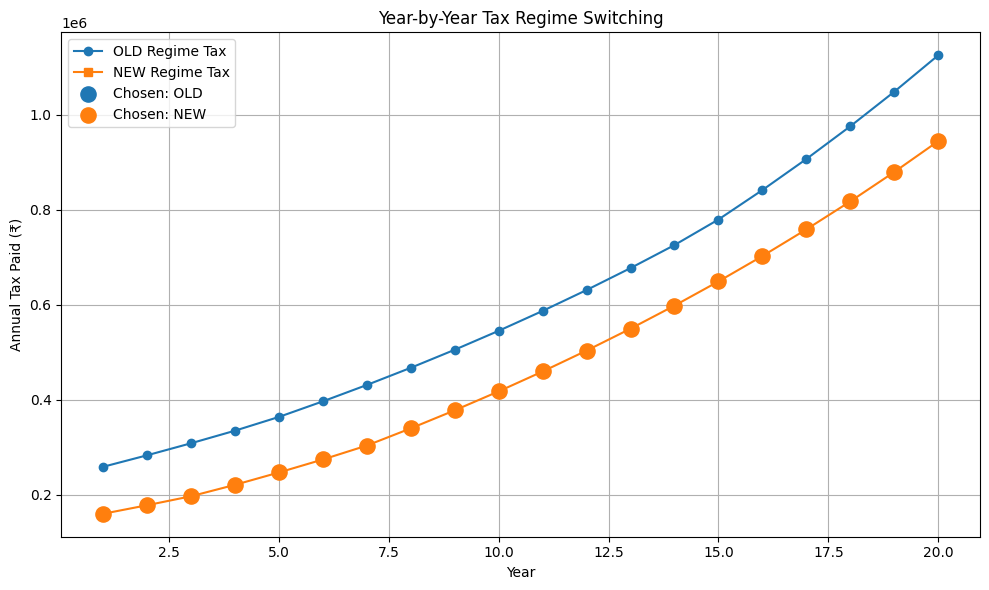

   property_price_lakhs chosen_tax_regime  monthly_emi  effective_monthly_emi  \
0                  66.3           DYNAMIC      44398.0                44398.0   
1                 275.0           DYNAMIC      54667.0                54667.0   
2                 134.0           DYNAMIC      54667.0                54667.0   
3                 151.0           DYNAMIC      54667.0                54667.0   
4                  74.9           DYNAMIC      50157.0                50157.0   

   final_buying_wealth_crore  final_renting_wealth_crore decision  
0                       2.21                        2.46     RENT  
1                       9.18                        4.63      BUY  
2                       4.48                        2.71      BUY  
3                       5.04                        4.24      BUY  
4                       2.50                        3.69     RENT  


In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

def visualize_yearly_tax_regimes(tax_df):
    years = tax_df["year"]

    tax_old = tax_df["tax_old"]
    tax_new = tax_df["tax_new"]

    chosen_old = tax_df["chosen_regime"] == "OLD"
    chosen_new = tax_df["chosen_regime"] == "NEW"

    plt.figure(figsize=(10, 6))

    # Tax curves
    plt.plot(years, tax_old, linestyle='-', marker='o', label="OLD Regime Tax")
    plt.plot(years, tax_new, linestyle='-', marker='s', label="NEW Regime Tax")

    # Highlight chosen regime per year
    plt.scatter(
        years[chosen_old],
        tax_old[chosen_old],
        s=120,
        label="Chosen: OLD",
        zorder=5
    )

    plt.scatter(
        years[chosen_new],
        tax_new[chosen_new],
        s=120,
        label="Chosen: NEW",
        zorder=5
    )

    plt.xlabel("Year")
    plt.ylabel("Annual Tax Paid (₹)")
    plt.title("Year-by-Year Tax Regime Switching")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# 1. TAX CALCULATION (OLD & NEW REGIME)
# ============================================================
def to_lakhs(amount):
    return amount / 1_00_000

def to_crores(amount):
    return amount / 1_00_00_000

def tax_old_regime(taxable_income, rebate_limit=500000):
    slabs = [(250000, 0.0), (500000, 0.05),
             (1000000, 0.20), (float("inf"), 0.30)]
    tax, prev = 0, 0
    for limit, rate in slabs:
        if taxable_income > prev:
            tax += (min(taxable_income, limit) - prev) * rate
            prev = limit
    return 0 if taxable_income <= rebate_limit else tax


def tax_new_regime(taxable_income, rebate_limit=1275000):
    slabs = [
        (400000, 0.0), (800000, 0.05),
        (1200000, 0.10), (1600000, 0.15),
        (2000000, 0.20), (2400000, 0.25),
        (float("inf"), 0.30)
    ]
    tax, prev = 0, 0
    for limit, rate in slabs:
        if taxable_income > prev:
            tax += (min(taxable_income, limit) - prev) * rate
            prev = limit
    return 0 if taxable_income <= rebate_limit else tax


def choose_best_regime_for_year(
    gross_income,
    interest_paid,
    principal_paid
):
    # OLD regime tax (with deductions)
    interest_ded = min(interest_paid, 200_000)
    principal_ded = min(principal_paid, 150_000)

    taxable_old = max(gross_income - interest_ded - principal_ded, 0)
    tax_old = tax_old_regime(taxable_old)

    # NEW regime tax (no deductions)
    tax_new = tax_new_regime(gross_income)

    if tax_old < tax_new:
        return "OLD", tax_old
    else:
        return "NEW", tax_new


# ============================================================
# 2. HOME LOAN & EMI HELPERS
# ============================================================

def average_home_loan_rate(bank_rates_fp):
    return float(np.mean(bank_rates_fp))


def calculate_emi(loan_amount, annual_rate, tenure_years):
    r = annual_rate / 12 / 100
    n = tenure_years * 12
    return loan_amount * r * (1 + r)**n / ((1 + r)**n - 1)


def loan_from_emi(emi, annual_rate, tenure_years):
    r = annual_rate / 12 / 100
    n = tenure_years * 12
    return emi * ((1 + r)**n - 1) / (r * (1 + r)**n)


# ============================================================
# 3. DOWN PAYMENT (RBI LTV)
# ============================================================

def min_down_payment_pct(property_price):
    if property_price <= 3_000_000:
        return 0.10
    elif property_price <= 7_500_000:
        return 0.20
    else:
        return 0.25


# ============================================================
# 4. EMI AMORTIZATION & YEARLY SPLIT
# ============================================================

def emi_amortization(loan_amount, annual_rate, tenure_years):
    emi = calculate_emi(loan_amount, annual_rate, tenure_years)
    r = annual_rate / 12 / 100
    n = tenure_years * 12

    balance = loan_amount
    rows = []

    for m in range(1, n + 1):
        interest = balance * r
        principal = emi - interest
        balance -= principal

        rows.append({
            "month": m,
            "emi": emi,
            "interest": interest,
            "principal": principal,
            "balance": max(balance, 0)
        })

    return pd.DataFrame(rows)


def yearly_emi_split(amort_df):
    amort_df["year"] = (amort_df["month"] - 1) // 12 + 1
    return amort_df.groupby("year").agg({
        "emi": "sum",
        "interest": "sum",
        "principal": "sum"
    }).reset_index()



def simulate_yearly_tax_switching(
    yearly_df,
    starting_income,
    salary_growth_rate
):
    income = starting_income
    results = []

    total_tax_paid = 0
    total_tax_old = 0
    total_tax_new = 0

    for year, row in yearly_df.iterrows():
        interest = row["interest"]
        principal = row["principal"]

        # Compare regimes
        chosen_regime, tax_paid = choose_best_regime_for_year(
            income,
            interest,
            principal
        )

        # Track both taxes for analysis
        tax_old = tax_old_regime(
            max(income - min(interest, 200_000) - min(principal, 150_000), 0)
        )
        tax_new = tax_new_regime(income)

        results.append({
            "year": year + 1,
            "income": income,
            "interest": interest,
            "principal": principal,
            "tax_old": tax_old,
            "tax_new": tax_new,
            "chosen_regime": chosen_regime,
            "tax_paid": tax_paid
        })

        total_tax_paid += tax_paid
        total_tax_old += tax_old
        total_tax_new += tax_new

        # Salary grows every year
        income *= (1 + salary_growth_rate)

    return pd.DataFrame(results), total_tax_paid, total_tax_old, total_tax_new



# ============================================================
# 5. TAX SAVINGS FROM HOME LOAN
# ============================================================

def tax_saved_from_home_loan(gross_income, interest_paid, principal_paid, tax_regime):
    if tax_regime != "OLD":
        return 0.0

    interest_ded = min(interest_paid, 200_000)
    principal_ded = min(principal_paid, 150_000)

    tax_without = tax_old_regime(gross_income)
    tax_with = tax_old_regime(
        max(gross_income - interest_ded - principal_ded, 0)
    )

    return tax_without - tax_with


def lifetime_tax_savings(yearly_df, gross_annual_income, tax_regime):
    total = 0
    for _, row in yearly_df.iterrows():
        total += tax_saved_from_home_loan(
            gross_annual_income,
            row["interest"],
            row["principal"],
            tax_regime
        )
    return total



# ============================================================
# 6. PRINCIPAL REINVESTMENT VALUE
# ============================================================

def principal_future_value(yearly_df, annual_return, tenure_years):
    corpus = 0
    for idx, row in yearly_df.iterrows():
        remaining_years = tenure_years - idx
        corpus += row["principal"] * ((1 + annual_return) ** remaining_years)
    return corpus


# ============================================================
# 7. RENTING MODEL
# ============================================================

def renting_model(
    initial_monthly_rent,
    down_payment,
    monthly_emi,
    rent_escalation_rate,
    investment_return,
    tenure_years,
    salary_growth_rate=0.05
):
    monthly_return = investment_return / 12
    total_months = tenure_years * 12

    monthly_rent = initial_monthly_rent
    monthly_income = monthly_emi   # lifestyle cap
    sip_corpus = 0.0

    for month in range(1, total_months + 1):
        available_surplus = monthly_income - monthly_rent
        monthly_sip = max(min(monthly_emi, available_surplus), 0)

        if monthly_sip > 0:
            remaining_months = total_months - month + 1
            sip_corpus += monthly_sip * ((1 + monthly_return) ** remaining_months)

        if month % 12 == 0:
            monthly_rent *= (1 + rent_escalation_rate)
            monthly_income *= (1 + salary_growth_rate)

    lump_sum_value = down_payment * ((1 + investment_return) ** tenure_years)
    return lump_sum_value + sip_corpus



# ============================================================
# 8. PROPERTY-LEVEL CALCULATION
# ============================================================

def process_property_row(
    property_price,
    initial_monthly_rent,
    gross_annual_income,
    avg_rate,
    tenure_years,
    emi_ratio,
    debug_plot=False
):
    # ---------- AFFORDABILITY ----------
    net_income = gross_annual_income - min(
        tax_old_regime(gross_annual_income),
        tax_new_regime(gross_annual_income)
    )

    max_emi = (net_income / 12) * emi_ratio
    max_loan = loan_from_emi(max_emi, avg_rate, tenure_years)

    dp_pct = min_down_payment_pct(property_price)
    down_payment = property_price * dp_pct
    loan_amount = min(property_price - down_payment, max_loan)

    monthly_emi = calculate_emi(loan_amount, avg_rate, tenure_years)

    # ---------- AMORTIZATION ----------
    amort_df = emi_amortization(loan_amount, avg_rate, tenure_years)
    yearly_df = yearly_emi_split(amort_df)

    tax_table, total_tax_paid, total_tax_old, total_tax_new = (
    simulate_yearly_tax_switching(
        yearly_df,
        gross_annual_income,
        salary_growth_rate=0.05
    )
)


    avg_annual_tax_saving = (total_tax_new - total_tax_paid) / tenure_years
    effective_monthly_emi = monthly_emi - (avg_annual_tax_saving / 12)

    chosen_regime = "DYNAMIC"



    # ---------- BUY SIDE ----------
    stamp_duty = property_price * 0.07
    maintenance = property_price * 0.015 * tenure_years
    property_tax = property_price * 0.008 * tenure_years
   

    final_property_value = property_price * (1.07 ** tenure_years)

    final_buying_wealth = (
        final_property_value
        - stamp_duty
        - maintenance
        - property_tax
    )

    # ---------- RENT SIDE ----------
    final_renting_wealth = renting_model(
        initial_monthly_rent,
        down_payment,
        effective_monthly_emi,
        0.05,
        0.10,
        tenure_years
    )

    decision = "RENT" if final_renting_wealth > final_buying_wealth else "BUY"

    


    if debug_plot:
        visualize_yearly_tax_regimes(tax_table)



    return {
    "property_price_lakhs": round(to_lakhs(property_price), 2),
    "chosen_tax_regime": chosen_regime,

    "monthly_emi": round(monthly_emi, 0),
    "effective_monthly_emi": round(effective_monthly_emi, 0),

    "final_buying_wealth_crore": round(to_crores(final_buying_wealth), 2),
    "final_renting_wealth_crore": round(to_crores(final_renting_wealth), 2),

    "decision": decision
}


# ============================================================
# 9. RUN FOR ENTIRE CSV
# ============================================================

def run_for_spreadsheet(
    csv_path,
    gross_annual_income,
    bank_rates_fp,
    tenure_years=20,
    emi_ratio=0.40
):
    df = pd.read_csv(csv_path)
    avg_rate = average_home_loan_rate(bank_rates_fp)

    results = []
    for i, row in df.iterrows():
        results.append(
            process_property_row(
                row["Price"],
                row["Rent"],
                gross_annual_income,
                avg_rate,
                tenure_years,
                emi_ratio,
                debug_plot=(i == 0)   # only first property
            )
        )

    return pd.DataFrame(results)


# ============================================================
# 10. EXECUTION
# ============================================================

if __name__ == "__main__":
    bank_rates_fp = [7.85, 8.0, 8.1, 7.9, 8.2]

    output = run_for_spreadsheet(
        csv_path="kolkata.csv",
        gross_annual_income=18_00_000,
        bank_rates_fp=bank_rates_fp
    )

    output.to_csv("buy_vs_rent_results.csv", index=False)

    print(output.head())


In [40]:
output['decision'].value_counts()

decision
RENT    2050
BUY     1398
Name: count, dtype: int64

In [41]:
output['chosen_tax_regime'].value_counts()

chosen_tax_regime
DYNAMIC    3448
Name: count, dtype: int64

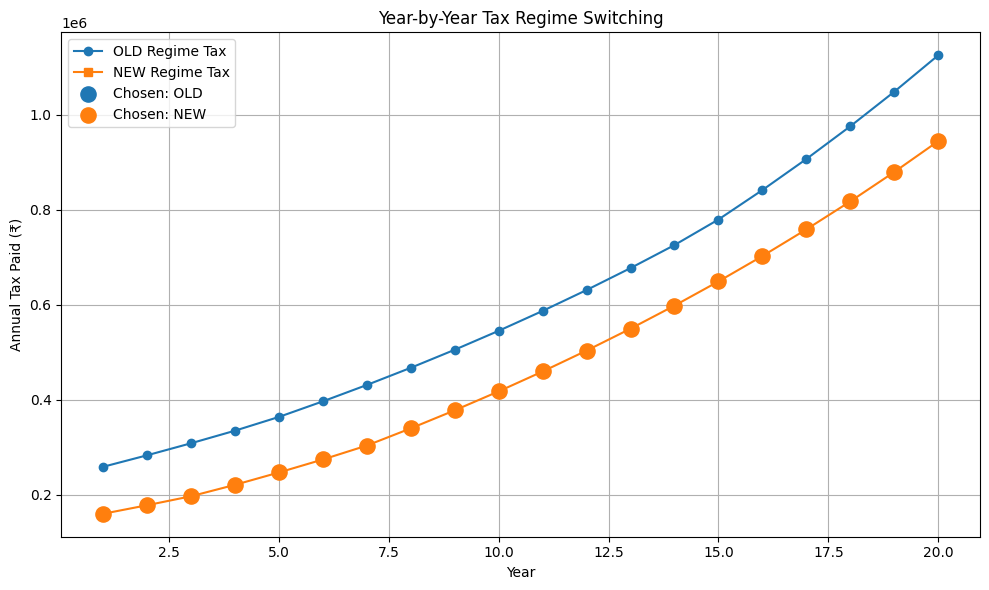

                                                Name          Address  \
0  2 BHK Apartment for Sale in Team Taurus Singha...         rajarhat   
1  3 BHK Apartment for Sale in Srijan Town Square...         new town   
2  4 BHK Apartment for Sale in Sattvik Gateway, N...         new town   
3  4 BHK Villa for Sale in Arizuma Southern Vista...  rajpur sonarpur   
4  3 BHK Apartment for Sale in Merlin Skygaze, Ea...        em bypass   

   Bedrooms       Price   Rent    Area   Furnishing  property_price  \
0         2   6630000.0  29925  1197.0  Unfurnished       6630000.0   
1         3  27500000.0  54640  2017.0  Unfurnished      27500000.0   
2         4  13400000.0  50468  1863.0  Unfurnished      13400000.0   
3         4  15100000.0  38918  1974.0  Unfurnished      15100000.0   
4         3   7490000.0  24805   840.0  Unfurnished       7490000.0   

   property_price_lakhs  initial_monthly_rent  ...  monthly_emi  \
0                  66.3                 29925  ...      44398.0   


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

def visualize_yearly_tax_regimes(tax_df):
    years = tax_df["year"]

    tax_old = tax_df["tax_old"]
    tax_new = tax_df["tax_new"]

    chosen_old = tax_df["chosen_regime"] == "OLD"
    chosen_new = tax_df["chosen_regime"] == "NEW"

    plt.figure(figsize=(10, 6))

    # Tax curves
    plt.plot(years, tax_old, linestyle='-', marker='o', label="OLD Regime Tax")
    plt.plot(years, tax_new, linestyle='-', marker='s', label="NEW Regime Tax")

    # Highlight chosen regime per year
    plt.scatter(
        years[chosen_old],
        tax_old[chosen_old],
        s=120,
        label="Chosen: OLD",
        zorder=5
    )

    plt.scatter(
        years[chosen_new],
        tax_new[chosen_new],
        s=120,
        label="Chosen: NEW",
        zorder=5
    )

    plt.xlabel("Year")
    plt.ylabel("Annual Tax Paid (₹)")
    plt.title("Year-by-Year Tax Regime Switching")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# 1. TAX CALCULATION (OLD & NEW REGIME)
# ============================================================
def to_lakhs(amount):
    return amount / 1_00_000

def to_crores(amount):
    return amount / 1_00_00_000

def tax_old_regime(taxable_income, rebate_limit=500000):
    slabs = [(250000, 0.0), (500000, 0.05),
             (1000000, 0.20), (float("inf"), 0.30)]
    tax, prev = 0, 0
    for limit, rate in slabs:
        if taxable_income > prev:
            tax += (min(taxable_income, limit) - prev) * rate
            prev = limit
    return 0 if taxable_income <= rebate_limit else tax


def tax_new_regime(taxable_income, rebate_limit=1275000):
    slabs = [
        (400000, 0.0), (800000, 0.05),
        (1200000, 0.10), (1600000, 0.15),
        (2000000, 0.20), (2400000, 0.25),
        (float("inf"), 0.30)
    ]
    tax, prev = 0, 0
    for limit, rate in slabs:
        if taxable_income > prev:
            tax += (min(taxable_income, limit) - prev) * rate
            prev = limit
    return 0 if taxable_income <= rebate_limit else tax


def choose_best_regime_for_year(
    gross_income,
    interest_paid,
    principal_paid
):
    # OLD regime tax (with deductions)
    interest_ded = min(interest_paid, 200_000)
    principal_ded = min(principal_paid, 150_000)

    taxable_old = max(gross_income - interest_ded - principal_ded, 0)
    tax_old = tax_old_regime(taxable_old)

    # NEW regime tax (no deductions)
    tax_new = tax_new_regime(gross_income)

    if tax_old < tax_new:
        return "OLD", tax_old
    else:
        return "NEW", tax_new


# ============================================================
# 2. HOME LOAN & EMI HELPERS
# ============================================================

def average_home_loan_rate(bank_rates_fp):
    return float(np.mean(bank_rates_fp))


def calculate_emi(loan_amount, annual_rate, tenure_years):
    r = annual_rate / 12 / 100
    n = tenure_years * 12
    return loan_amount * r * (1 + r)**n / ((1 + r)**n - 1)


def loan_from_emi(emi, annual_rate, tenure_years):
    r = annual_rate / 12 / 100
    n = tenure_years * 12
    return emi * ((1 + r)**n - 1) / (r * (1 + r)**n)


# ============================================================
# 3. DOWN PAYMENT (RBI LTV)
# ============================================================

def min_down_payment_pct(property_price):
    if property_price <= 3_000_000:
        return 0.10
    elif property_price <= 7_500_000:
        return 0.20
    else:
        return 0.25


# ============================================================
# 4. EMI AMORTIZATION & YEARLY SPLIT
# ============================================================

def emi_amortization(loan_amount, annual_rate, tenure_years):
    emi = calculate_emi(loan_amount, annual_rate, tenure_years)
    r = annual_rate / 12 / 100
    n = tenure_years * 12

    balance = loan_amount
    rows = []

    for m in range(1, n + 1):
        interest = balance * r
        principal = emi - interest
        balance -= principal

        rows.append({
            "month": m,
            "emi": emi,
            "interest": interest,
            "principal": principal,
            "balance": max(balance, 0)
        })

    return pd.DataFrame(rows)


def yearly_emi_split(amort_df):
    amort_df["year"] = (amort_df["month"] - 1) // 12 + 1
    return amort_df.groupby("year").agg({
        "emi": "sum",
        "interest": "sum",
        "principal": "sum"
    }).reset_index()



def simulate_yearly_tax_switching(
    yearly_df,
    starting_income,
    salary_growth_rate
):
    income = starting_income
    results = []

    total_tax_paid = 0
    total_tax_old = 0
    total_tax_new = 0

    for year, row in yearly_df.iterrows():
        interest = row["interest"]
        principal = row["principal"]

        # Compare regimes
        chosen_regime, tax_paid = choose_best_regime_for_year(
            income,
            interest,
            principal
        )

        # Track both taxes for analysis
        tax_old = tax_old_regime(
            max(income - min(interest, 200_000) - min(principal, 150_000), 0)
        )
        tax_new = tax_new_regime(income)

        results.append({
            "year": year + 1,
            "income": income,
            "interest": interest,
            "principal": principal,
            "tax_old": tax_old,
            "tax_new": tax_new,
            "chosen_regime": chosen_regime,
            "tax_paid": tax_paid
        })

        total_tax_paid += tax_paid
        total_tax_old += tax_old
        total_tax_new += tax_new

        # Salary grows every year
        income *= (1 + salary_growth_rate)

    return pd.DataFrame(results), total_tax_paid, total_tax_old, total_tax_new



# ============================================================
# 5. TAX SAVINGS FROM HOME LOAN
# ============================================================

def tax_saved_from_home_loan(gross_income, interest_paid, principal_paid, tax_regime):
    if tax_regime != "OLD":
        return 0.0

    interest_ded = min(interest_paid, 200_000)
    principal_ded = min(principal_paid, 150_000)

    tax_without = tax_old_regime(gross_income)
    tax_with = tax_old_regime(
        max(gross_income - interest_ded - principal_ded, 0)
    )

    return tax_without - tax_with


def lifetime_tax_savings(yearly_df, gross_annual_income, tax_regime):
    total = 0
    for _, row in yearly_df.iterrows():
        total += tax_saved_from_home_loan(
            gross_annual_income,
            row["interest"],
            row["principal"],
            tax_regime
        )
    return total



# ============================================================
# 6. PRINCIPAL REINVESTMENT VALUE
# ============================================================

def principal_future_value(yearly_df, annual_return, tenure_years):
    corpus = 0
    for idx, row in yearly_df.iterrows():
        remaining_years = tenure_years - idx
        corpus += row["principal"] * ((1 + annual_return) ** remaining_years)
    return corpus


# ============================================================
# 7. RENTING MODEL
# ============================================================

def renting_model(
    initial_monthly_rent,
    down_payment,
    monthly_emi,
    rent_escalation_rate,
    investment_return,
    tenure_years,
    salary_growth_rate=0.05
):
    monthly_return = investment_return / 12
    total_months = tenure_years * 12

    monthly_rent = initial_monthly_rent
    monthly_income = monthly_emi   # lifestyle cap
    sip_corpus = 0.0

    for month in range(1, total_months + 1):
        available_surplus = monthly_income - monthly_rent
        monthly_sip = max(min(monthly_emi, available_surplus), 0)

        if monthly_sip > 0:
            remaining_months = total_months - month + 1
            sip_corpus += monthly_sip * ((1 + monthly_return) ** remaining_months)

        if month % 12 == 0:
            monthly_rent *= (1 + rent_escalation_rate)
            monthly_income *= (1 + salary_growth_rate)

    lump_sum_value = down_payment * ((1 + investment_return) ** tenure_years)
    return lump_sum_value + sip_corpus



# ============================================================
# 8. PROPERTY-LEVEL CALCULATION
# ============================================================

def process_property_row(
    property_price,
    initial_monthly_rent,
    gross_annual_income,
    avg_rate,
    tenure_years,
    emi_ratio,
    debug_plot=False
):
    # ---------- AFFORDABILITY ----------
    net_income = gross_annual_income - min(
        tax_old_regime(gross_annual_income),
        tax_new_regime(gross_annual_income)
    )

    max_emi = (net_income / 12) * emi_ratio
    max_loan = loan_from_emi(max_emi, avg_rate, tenure_years)

    dp_pct = min_down_payment_pct(property_price)
    down_payment = property_price * dp_pct
    loan_amount = min(property_price - down_payment, max_loan)

    monthly_emi = calculate_emi(loan_amount, avg_rate, tenure_years)

    # ---------- AMORTIZATION ----------
    amort_df = emi_amortization(loan_amount, avg_rate, tenure_years)
    yearly_df = yearly_emi_split(amort_df)

    tax_table, total_tax_paid, total_tax_old, total_tax_new = (
    simulate_yearly_tax_switching(
        yearly_df,
        gross_annual_income,
        salary_growth_rate=0.05
    )
)


    avg_annual_tax_saving = (total_tax_new - total_tax_paid) / tenure_years
    effective_monthly_emi = monthly_emi - (avg_annual_tax_saving / 12)

    chosen_regime = "DYNAMIC"



    # ---------- BUY SIDE ----------
    stamp_duty = property_price * 0.07
    maintenance = property_price * 0.015 * tenure_years
    property_tax = property_price * 0.008 * tenure_years
   

    final_property_value = property_price * (1.07 ** tenure_years)

    final_buying_wealth = (
        final_property_value
        - stamp_duty
        - maintenance
        - property_tax
    )

    # ---------- RENT SIDE ----------
    final_renting_wealth = renting_model(
        initial_monthly_rent,
        down_payment,
        effective_monthly_emi,
        0.05,
        0.10,
        tenure_years
    )

    decision = "RENT" if final_renting_wealth > final_buying_wealth else "BUY"
    # [ADDED] Pre-calculate Wealth Difference for RAG
    wealth_difference = final_buying_wealth - final_renting_wealth
    


    if debug_plot:
        visualize_yearly_tax_regimes(tax_table)



    return {
    # ---------- INPUTS ----------
    "property_price": property_price,
    "property_price_lakhs": round(to_lakhs(property_price), 2),
    "initial_monthly_rent": initial_monthly_rent,

    # ---------- AFFORDABILITY ----------
    "down_payment_pct": dp_pct,
    "down_payment": round(down_payment, 0),
    "loan_amount": round(loan_amount, 0),

    # ---------- EMI ----------
    "monthly_emi": round(monthly_emi, 0),
    "effective_monthly_emi": round(effective_monthly_emi, 0),

    # ---------- TAX ----------
    "chosen_tax_regime": chosen_regime,
    "total_tax_paid": round(total_tax_paid, 0),
    "total_tax_old": round(total_tax_old, 0),
    "total_tax_new": round(total_tax_new, 0),

    # ---------- FINAL WEALTH ----------
    "final_property_value": round(final_property_value, 0),
    "final_buying_wealth": round(final_buying_wealth, 0),
    "final_renting_wealth": round(final_renting_wealth, 0),

    # [ADDED]
    "wealth_difference": round(wealth_difference, 0),

    # ---------- DECISION ----------
    "decision": decision
}



# ============================================================
# 9. RUN FOR ENTIRE CSV
# ============================================================

def run_for_spreadsheet(
    csv_path,
    gross_annual_income,
    bank_rates_fp,
    tenure_years=20,
    emi_ratio=0.40
):
    input_df = pd.read_csv(csv_path)
    avg_rate = average_home_loan_rate(bank_rates_fp)

    result_rows = []

    for i, row in input_df.iterrows():
        computed = process_property_row(
            property_price=row["Price"],
            initial_monthly_rent=row["Rent"],
            gross_annual_income=gross_annual_income,
            avg_rate=avg_rate,
            tenure_years=tenure_years,
            emi_ratio=emi_ratio,
            debug_plot=(i == 0)
        )

        # 🔥 MERGE original row + computed values
        merged_row = {**row.to_dict(), **computed}
        result_rows.append(merged_row)

    return pd.DataFrame(result_rows)


# ============================================================
# 10. EXECUTION
# ============================================================

if __name__ == "__main__":
    bank_rates_fp = [7.85, 8.0, 8.1, 7.9, 8.2]

    output = run_for_spreadsheet(
        csv_path="kolkata.csv",
        gross_annual_income=18_00_000,
        bank_rates_fp=bank_rates_fp
    )

    output.to_csv("kolkata_buy_vs_rent_full_analysis.csv", index=False)

    print(output.head())
